In [1]:
from tensorflow.keras.models import load_model

loaded_model = load_model('saved_models/NVspin_SimpleRNN_model.h5')
# loaded_model = load_model('saved_models/NVspin_LSTM_model.h5')
# loaded_model = load_model('saved_models/NVspin_GRU_model.h5')

In [2]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm, fractional_matrix_power

#########################################################################

# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
dt = 2.6 


# unitary operator
def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


#########################################################################

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)


#########################################################################

init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave,init_wave.conj().T)


def fidelity(target_theta, target_phi):
    
    target_U = Rz(target_phi) @ Rx(target_theta)
    irho_target = target_U @ irho_init @ target_U.conj().T

    new_theta = np.array(target_theta).reshape(-1, 1)
    new_phi = np.array(target_phi).reshape(-1, 1)
    predicted_sequence = loaded_model.predict([new_theta, new_phi])

    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)

    Uni = s0
    U_0 = unitary(dt, 0)
    U_1 = unitary(dt, 1)
    U_2 = unitary(dt, 2)
    U_3 = unitary(dt, 3)
    U_4 = unitary(dt, 4)
    
    pulse_list = [U_0, U_1, U_2, U_3, U_4]
    
    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,irho_target))
    
    return  F

In [3]:
import pandas as pd

# 데이터 불러오기
data = pd.read_csv("data_results/NVspin_SimpleRNN_data_results.csv")

# theta와 phi 값들을 numpy 배열로 변환
thetas = data['Theta'].to_numpy()
phis = data['Phi'].to_numpy()

sum = 0
iter = len(thetas)
num = 0
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

# theta와 phi 값들을 반복하며 fidelity 계산
for target_theta, target_phi in zip(thetas, phis):  
     
     temp = fidelity(target_theta, target_phi)
     fidelities.append(temp)
     
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     
     sum += temp
     
     num += 1
     print(num, "/", iter)

print(sum/iter)

1/1 [==============================] - 1s 511ms/step
1 / 17254
1/1 [==============================] - 0s 42ms/step
2 / 17254
1/1 [==============================] - 0s 128ms/step
3 / 17254
1/1 [==============================] - 0s 36ms/step
4 / 17254
1/1 [==============================] - 0s 149ms/step
5 / 17254
1/1 [==============================] - 0s 34ms/step
6 / 17254
1/1 [==============================] - 0s 57ms/step
7 / 17254
1/1 [==============================] - 0s 75ms/step
8 / 17254
1/1 [==============================] - 0s 107ms/step
9 / 17254
1/1 [==============================] - 0s 37ms/step
10 / 17254
1/1 [==============================] - 0s 41ms/step
11 / 17254
1/1 [==============================] - 0s 136ms/step
12 / 17254
1/1 [==============================] - 0s 59ms/step
13 / 17254
1/1 [==============================] - 0s 46ms/step
14 / 17254
1/1 [==============================] - 0s 43ms/step
15 / 17254
1/1 [==============================] - 0s 38ms/step
16 / 17

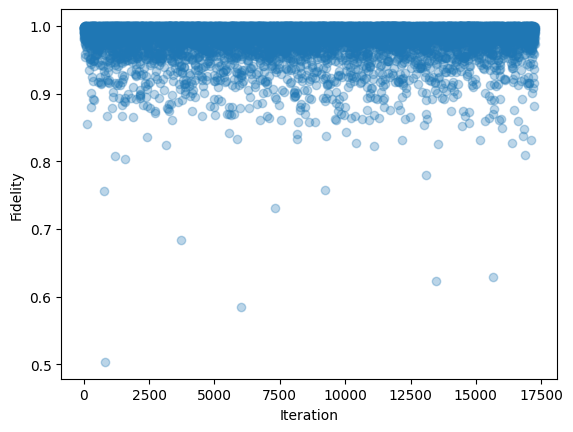

In [4]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.3)
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.show()

In [5]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

2 0.9829456506920512
20 0.9886362540091639
21 0.9813075279715269
24 0.9853194210820532
25 0.9802148204088693
29 0.9747275941283533
32 0.9876043150289185
38 0.9584413634505061
41 0.9891415108711664
53 0.9727903136261979
57 0.9795096053538008
59 0.9855233650656545
60 0.9833754168182033
61 0.9810241981486149
64 0.9536957552224384
66 0.98439533584605
67 0.9707670752477309
68 0.9896918637151564
82 0.9880764994798974
85 0.989984468461516
86 0.9899344951942988
97 0.9755988794229251
99 0.9692987574654331
108 0.9837885801831436
115 0.9871271059692699
120 0.8551171971060453
122 0.9763663246656952
135 0.9630852589798489
137 0.9759222232868767
142 0.9830722515532998
144 0.9822739402422062
158 0.954853559416364
159 0.988201311513055
163 0.989080520865205
178 0.9794224249577455
181 0.9887992677462639
184 0.9838093847828016
189 0.9893631191149506
192 0.972467976984287
194 0.934849293597888
200 0.9896022772569983
201 0.9682421877403804
203 0.9871629163199197
204 0.9883125345572397
209 0.98992345508285

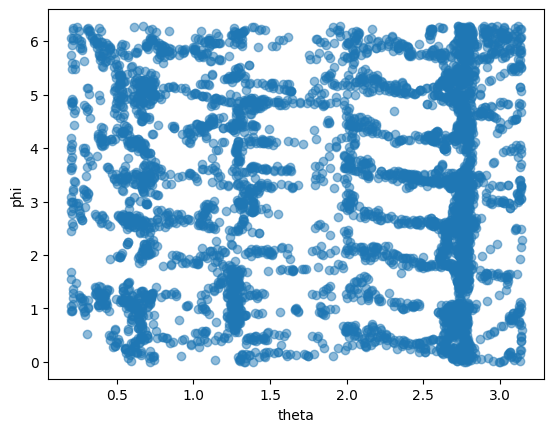

In [6]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.5)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()

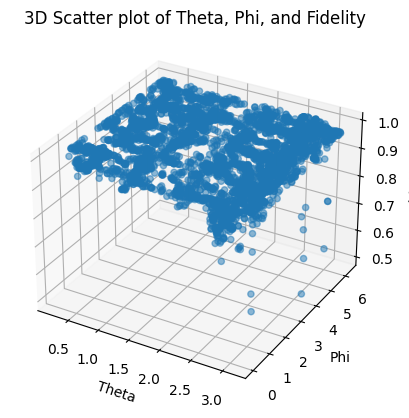

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(low_fidelities['theta'], low_fidelities['phi'], low_fidelities['fidelity'], alpha=0.5)
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.set_zlabel('Fidelity')
plt.title('3D Scatter plot of Theta, Phi, and Fidelity')
plt.show()
